# Patient Adherence
Author: Kunehi Parekh

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pandas import pivot_table
from datetime import datetime
import calendar

In [3]:
#get dataset
data = pd.read_csv('C:/Users/kparekh/Downloads/doses.csv')
data.head()

,Patient ID,Enroll Date,Activation Time,End Date,Date Recorded,Time Recorded,Deadline,Outcome
0,7953,7/17/2017,7/19/2017 18:49,NaN,7/19/2017,0 days 18:49:07.000000000,0 days 01:00:00.000000000,LATE
1,7953,7/17/2017,7/19/2017 18:49,NaN,7/20/2017,0 days 01:00:48.000000000,0 days 01:00:00.000000000,ONTIME
2,7953,7/17/2017,7/19/2017 18:49,NaN,7/21/2017,0 days 01:01:15.000000000,0 days 01:00:00.000000000,ONTIME
3,7953,7/17/2017,7/19/2017 18:49,NaN,7/22/2017,0 days 01:01:09.000000000,0 days 01:00:00.000000000,ONTIME
4,7953,7/17/2017,7/19/2017 18:49,NaN,7/23/2017,0 days 01:02:05.000000000,0 days 01:00:00.000000000,ONTIME


In [75]:
#check shape of data
data.shape

(99670, 8)

In [76]:
#check data types
data.dtypes

Patient ID          int64
Enroll Date        object
Activation Time    object
End Date           object
Date Recorded      object
Time Recorded      object
Deadline           object
Outcome            object
dtype: object

In [122]:
#clean and format data
data['Patient ID'] = data['Patient ID'].astype(int)
data['Enroll Date'] = pd.to_datetime(data['Enroll Date'], format='%m/%d/%Y')
data['End Date'] = pd.to_datetime(data['End Date'], format='%m/%d/%Y')
data = data.drop('Activation Time', 1) #inconsistent format - date or time?
data = data.dropna(subset=['Outcome']) 
def findDay(date): 
    recorded = datetime.strptime(date, '%m/%d/%Y').weekday() 
    return (calendar.day_name[recorded])
data['dayofweek'] = data['Date Recorded'].apply(findDay)
data['Date Recorded'] = pd.to_datetime(data['Date Recorded'], format='%m/%d/%Y')

In [123]:
#feature engineering
data['Days_Since_Enrolled'] = (data['Date Recorded'] - data['Enroll Date']).dt.days
data['Days_To_End'] = (data['End Date'] - data['Date Recorded']).dt.days
data['TimeRecorded_clean_hour'] = data['Time Recorded'].str.slice(7,9)
data['TimeRecorded_clean_hour'] = data['TimeRecorded_clean_hour'].fillna(0)
data['Deadline_clean_hour'] = data['Deadline'].str.slice(7,9)
data['Recorded_Minus_Deadline_Hours'] = data['Deadline_clean_hour'].astype(int) - data['TimeRecorded_clean_hour'].astype(int)
data.head()

,Patient ID,Enroll Date,End Date,Date Recorded,Time Recorded,Deadline,Outcome,dayofweek,Days_Since_Enrolled,Days_To_End,TimeRecorded_clean_hour,Deadline_clean_hour,Recorded_Minus_Deadline_Hours
0,3972,2017-07-17,NaT,2017-07-19,0 days 18:49:07.000000000,0 days 01:00:00.000000000,LATE,Wednesday,2,NaN,18,01,-17
1,3972,2017-07-17,NaT,2017-07-20,0 days 01:00:48.000000000,0 days 01:00:00.000000000,ONTIME,Thursday,3,NaN,01,01,0
2,3972,2017-07-17,NaT,2017-07-21,0 days 01:01:15.000000000,0 days 01:00:00.000000000,ONTIME,Friday,4,NaN,01,01,0
3,3972,2017-07-17,NaT,2017-07-22,0 days 01:01:09.000000000,0 days 01:00:00.000000000,ONTIME,Saturday,5,NaN,01,01,0
4,3972,2017-07-17,NaT,2017-07-23,0 days 01:02:05.000000000,0 days 01:00:00.000000000,ONTIME,Sunday,6,NaN,01,01,0


In [89]:
data.isnull().sum()

Patient ID                     0
Enroll Date                    0
End Date                   67085
Date Recorded                  0
Time Recorded                  0
Deadline                       0
Outcome                        0
Days_Since_Enrolled            0
Days_To_End                67085
TimeRecorded_clean_hour        0
Deadline_clean_hour            0
dtype: int64

In [64]:
data.dtypes

Patient ID                                  int32
Enroll Date                        datetime64[ns]
End Date                           datetime64[ns]
Date Recorded                      datetime64[ns]
Time Recorded                              object
Deadline                                   object
Outcome                                    object
Days_Since_Enrolled                         int64
Days_To_End                               float64
Time_Recorded_clean                datetime64[ns]
Deadline_clean                     datetime64[ns]
Recorded_Minus_Deadline_Hours             float64
Recorded_Minus_Deadline_Minutes           float64
dtype: object

**How would you calculate patient compliance?**

One way to calculate patient compliance is of the number of observations, how many did they miss? This calculation provides a good measure of the degree to which a patient correctly follows medical advice without missing dosage.

In [30]:
missed = data[data['Outcome'] == 'MISSED']['Outcome'].groupby(data['Patient ID']).count()
missed = missed.rename_axis('Patient ID').reset_index(name='Missed')
total = data['Outcome'].groupby(data['Patient ID']).count()
total = total.rename_axis('Patient ID').reset_index(name='Total')
compliance = total.merge(missed, on='Patient ID', how='left')
compliance['Missed'] = compliance['Missed'].fillna(0)
compliance['ComplianceRate'] = 1 - (compliance['Missed']/compliance['Total'])
compliance.ComplianceRate.describe().round(2)

count    303.00
mean       0.93
std        0.17
min        0.00
25%        0.96
50%        0.99
75%        1.00
max        1.00
Name: ComplianceRate, dtype: float64

In [36]:
compliance.head()

,Patient ID,Total,Missed,ComplianceRate
0,3972,743,59.0,0.920592
1,3985,735,7.0,0.990476
2,3986,194,3.0,0.984536
3,3998,161,0.0,1.000000
4,4023,732,38.0,0.948087


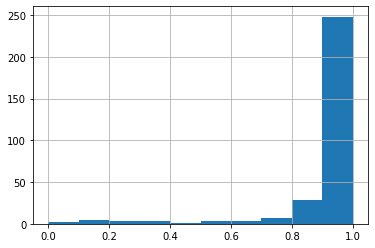

In [32]:
compliance.ComplianceRate.hist()

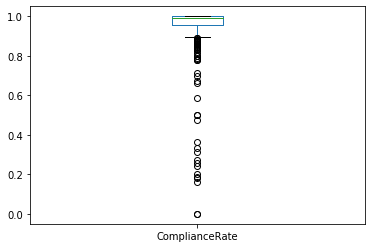

In [35]:
compliance.ComplianceRate.plot(kind='box')

Average compliance rate looks pretty good at 93%. From the plots above, we can see that the distribution is mostly focused in the high compliance rates. The median is 99% which means there are outliers that influence the overall average.

**What interesting correlations and trends do you see in the data relating to compliance?**

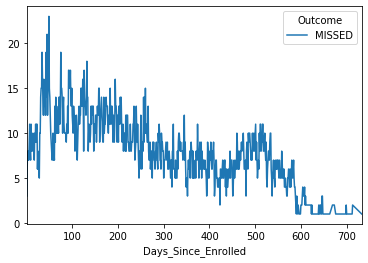

In [51]:
data[data.Outcome=='MISSED'].pivot_table(values='Patient ID', index='Days_Since_Enrolled', columns='Outcome', aggfunc=lambda x: len(x.unique())).plot(kind='line')

Most patients miss their dosage in the early days of their enrollment. Maybe they need more hand-holding (engagement) for up to the first three months or so. 

In [95]:
data[data.Outcome.isin(['EARLY', 'LATE'])].Recorded_Minus_Deadline_Hours.groupby(data.Outcome).mean().round()

Outcome
EARLY   -2.0
LATE     2.0
Name: Recorded_Minus_Deadline_Hours, dtype: float64

Patients are ususally early or late by 2 hours when they are not on time.

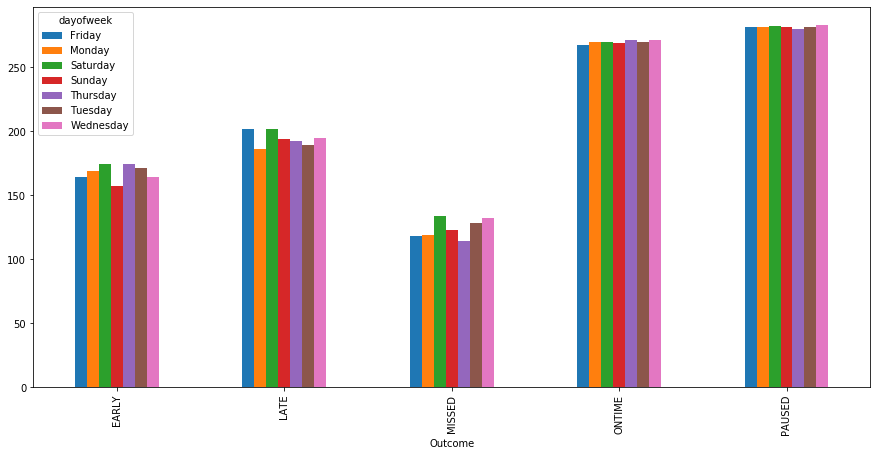

In [137]:
data.pivot_table(values='Patient ID', index='Outcome', columns='dayofweek', aggfunc=lambda x: len(x.unique())).plot(kind='bar', figsize = (15,7))

From the chart above, we can see that:
 * least number of patients are early on Sundays
 * most people are late on Mondays
 * most people missed on Saturdays
 * middle of the week is usually when patients are on time in taking their meds

Poosibly send more notifications/texts in the beginning of the week and during the weekend.

**How would you approach trying to predict missed doses?**

One way would be to look at their recent outcome history by calculating a running compliance rate. Over the last week or last few days, how many times have they missed? Based on this data, are there certain days of the week when they're likely to miss (i.e. weekends)? 

Most people miss because they forget. It would be interesting to check the correlation between the number of reminders sent and whether they took their dose. Engagement could be a good predictor.

Sometimes patients just might not be feeling well or feeling demotivated to take their pills. They may be going through side effects or feeling overwhelmed to continue. These are difficult things to expect or predict. But Any sort of daily measure of how they are feeling could help determine whether they will miss their dosage. 

**How would you approach trying to predict disenrollment?**

Lack of engagement could be a significant predictor of disinterest and possibly disenrollment. Are they using the bottle? Are they taking their pills on time? Are they replying acknowledging/replying to emails/texts/reminders/feedback requests? Are their survey/feedback results positive? 

Looking at patient's demographic attributes could also help predict disenrollment. Younger patients may shop around and switch to a competitor so the age of the patient may be a good predictor. How long the patient has been enrolled and over time how their compliance has improved/worsened can also be predictive. If they're seeing good results, they'll continue.

Pricing could be a factor as well.

Given these data points and a good volume of patient data, a binary classifier could be trained to target patients at risk of discontinuing.